# **Homework 6:** Optimization and Normalization

# Part 0: Enviornment Setup

For this homework and for the final project, you may find it useful to run your code with access to a sufficient GPU, which may allow your code to run faster (we will talk about why later in the course). If you do not have access to a powerful GPU on your personal computer (e.g. if you primarily use a laptop), then there are 2 options you may consider for using a remotely hosted GPU.

*Note that some laptops may actually run this code faster than the course server, so you may want to try it first on your laptop regardless*

In [1]:
# This is the path that the dataset for this homework will be downloaded to. 
# If you are running on the course server or Colab you can keep this line, if you are
# running on a personal computer, you may want to change this location.
data_path = './data' #'/cs/cs152/data'

## Set Hyperparameters

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchsummary import summary

from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, Normalize, ToTensor

from fastprogress.fastprogress import master_bar, progress_bar

import matplotlib.pyplot as plt

In [3]:
# Use the GPUs if they are available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device.")

# Model hyperparameters
neurons_per_hidden_layer = [20] * 2

# Mini-Batch SGD hyperparameters
batch_size = 256
num_epochs = 10
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

Using 'cpu' device.


## Prepare the Dataset

In [4]:
def get_fmnist_data_loaders(path, batch_size, valid_batch_size=0):
    # Computing normalization constants for Fashion-MNIST (commented out since we only need to do this once)
    # train_loader, valid_loader = get_fmnist_data_loaders(data_path, 0)
    # X, _ = next(iter(train_loader))
    # s, m = torch.std_mean(X)


    # Data specific transforms
    data_mean = (0.2860,)
    data_std = (0.3530,)
    xforms = Compose([ToTensor(), Normalize(data_mean, data_std)])

    # Training data loader
    train_dataset = FashionMNIST(root=path, train=True, download=True, transform=xforms)

    # Set the batch size to N if batch_size is 0
    tbs = len(train_dataset) if batch_size == 0 else batch_size
    train_loader = DataLoader(train_dataset, batch_size=tbs, shuffle=True)

    # Validation data loader
    valid_dataset = FashionMNIST(root=path, train=False, download=True, transform=xforms)

    # Set the batch size to N if batch_size is 0
    vbs = len(valid_dataset) if valid_batch_size == 0 else valid_batch_size
    valid_loader = DataLoader(valid_dataset, batch_size=vbs, shuffle=True)

    return train_loader, valid_loader

In [5]:
# Load the example dataset (Fashion MNIST)
train_loader, valid_loader = get_fmnist_data_loaders(data_path, batch_size)

print("Training dataset shape   :", train_loader.dataset.data.shape)
print("Validation dataset shape :", valid_loader.dataset.data.shape)

Training dataset shape   : torch.Size([60000, 28, 28])
Validation dataset shape : torch.Size([10000, 28, 28])


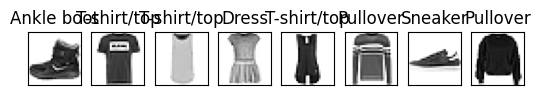

In [6]:
# Let's plot a few images as an example
num_to_show = 8
images = train_loader.dataset.data[:num_to_show]
targets = train_loader.dataset.targets[:num_to_show]
labels = [train_loader.dataset.classes[t] for t in targets]

fig, axes = plt.subplots(1, num_to_show)

for axis, image, label in zip(axes, images, labels):
    axis.imshow(image.squeeze(), cmap="Greys")
    axis.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_title(f"{label}")

## Create a Neural Network

In [7]:
class Layer(nn.Module):
    # This class will represent a basic neural network layer with a linear function
    # and an activation (in this case ReLU)
    def __init__(self, in_dimensions, out_dimensions):
        super().__init__()
        self.linear = nn.Linear(in_dimensions, out_dimensions)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        return x

class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, layer_class=Layer):
        super(NeuralNetwork, self).__init__()

        # The first "layer" just rearranges the Nx28x28 input into Nx784
        first_layer = nn.Flatten()

        # The hidden layers include:
        # 1. a linear component (computing Z) and
        # 2. a non-linear comonent (computing A)
        hidden_layers = [
            (layer_class(nlminus1, nl) if nlminus1 == nl else Layer(nlminus1, nl))
            for nl, nlminus1 in zip(layer_sizes[1:-1], layer_sizes)
        ]

        # The output layer must be Linear without an activation. See:
        #   https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        output_layer = nn.Linear(layer_sizes[-2], layer_sizes[-1])

        # Group all layers into the sequential container
        all_layers = [first_layer] + hidden_layers + [output_layer]
        self.layers = nn.Sequential(*all_layers)

    def forward(self, X):
        return self.layers(X)

## Implement an Optimizer

In [8]:
class SGDOptimizer:
    def __init__(self, parameters, lr=0.01):
        # Set the learning rate
        self.lr = lr
        # Store the set of parameters that we'll be optimizing
        self.parameters = list(parameters)

    def step(self):
        # Take a step of gradient descent
        for ind, parameter in enumerate(self.parameters):
            # Compute the update to the parameter
            update = self.lr * parameter.grad

            # Update the parameter: w <- w - lr * grad
            parameter -= update 

## Train Classifier

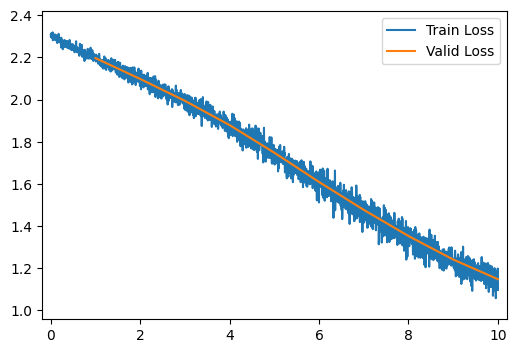

[10/10] Train Loss = 1.1842; Valid Loss = 1.1478; Valid Accuracy = 65.2%


In [9]:
# Here we'll define a function to train and evaluate a neural network with a specified architecture
# using a specified optimizer.
def run_model(optimizer=SGDOptimizer, 
              layer_type=Layer, 
              number_of_hidden_layers=2,
              neurons_per_hidden_layer=20, 
              learning_rate=0.001):
    
    # Get the dataset
    train_loader, valid_loader = get_fmnist_data_loaders(data_path, batch_size)

    # The input layer size depends on the dataset
    nx = train_loader.dataset.data.shape[1:].numel()

    # The output layer size depends on the dataset
    ny = len(train_loader.dataset.classes)

    # Preprend the input and append the output layer sizes
    layer_sizes = [nx] + [neurons_per_hidden_layer] * number_of_hidden_layers + [ny]

    # Do model creation here so that the model is recreated each time the cell is run
    model = NeuralNetwork(layer_sizes, layer_type).to(device)

    t = 0
    # Create the optimizer, just like we have with the built-in optimizer
    opt = optimizer(model.parameters(), learning_rate)

    # A master bar for fancy output progress
    mb = master_bar(range(num_epochs))

    # Information for plots
    mb.names = ["Train Loss", "Valid Loss"]
    train_losses = []
    valid_losses = []

    for epoch in mb:

        #
        # Training
        #
        model.train()

        train_N = len(train_loader.dataset)
        num_train_batches = len(train_loader)
        train_dataiterator = iter(train_loader)

        train_loss_mean = 0

        for batch in progress_bar(range(num_train_batches), parent=mb):

            # Grab the batch of data and send it to the correct device
            train_X, train_Y = next(train_dataiterator)
            train_X, train_Y = train_X.to(device), train_Y.to(device)

            # Compute the output
            train_output = model(train_X)

            # Compute loss
            train_loss = criterion(train_output, train_Y)

            num_in_batch = len(train_X)
            tloss = train_loss.item() * num_in_batch / train_N
            train_loss_mean += tloss
            train_losses.append(train_loss.item())

            # Compute gradient
            model.zero_grad()
            train_loss.backward()
            
            # Take a step of gradient descent
            t += 1
            with torch.no_grad():
                opt.step()

        #
        # Validation
        #
        model.eval()

        valid_N = len(valid_loader.dataset)
        num_valid_batches = len(valid_loader)

        valid_loss_mean = 0
        valid_correct = 0

        with torch.no_grad():

            # valid_loader is probably just one large batch, so not using progress bar
            for valid_X, valid_Y in valid_loader:

                valid_X, valid_Y = valid_X.to(device), valid_Y.to(device)

                valid_output = model(valid_X)

                valid_loss = criterion(valid_output, valid_Y)

                num_in_batch = len(valid_X)
                vloss = valid_loss.item() * num_in_batch / valid_N
                valid_loss_mean += vloss
                valid_losses.append(valid_loss.item())

                # Convert network output into predictions (one-hot -> number)
                predictions = valid_output.argmax(1)

                # Sum up total number that were correct
                valid_correct += (predictions == valid_Y).type(torch.float).sum().item()

        valid_accuracy = 100 * (valid_correct / valid_N)

        # Report information
        tloss = f"Train Loss = {train_loss_mean:.4f}"
        vloss = f"Valid Loss = {valid_loss_mean:.4f}"
        vaccu = f"Valid Accuracy = {(valid_accuracy):>0.1f}%"
        mb.write(f"[{epoch+1:>2}/{num_epochs}] {tloss}; {vloss}; {vaccu}")

        # Update plot data
        max_loss = max(max(train_losses), max(valid_losses))
        min_loss = min(min(train_losses), min(valid_losses))

        x_margin = 0.2
        x_bounds = [0 - x_margin, num_epochs + x_margin]

        y_margin = 0.1
        y_bounds = [min_loss - y_margin, max_loss + y_margin]

        valid_Xaxis = torch.linspace(0, epoch + 1, len(train_losses))
        valid_xaxis = torch.linspace(1, epoch + 1, len(valid_losses))
        graph_data = [[valid_Xaxis, train_losses], [valid_xaxis, valid_losses]]

        mb.update_graph(graph_data, x_bounds, y_bounds)

    print(f"[{epoch+1:>2}/{num_epochs}] {tloss}; {vloss}; {vaccu}")

run_model()

# Part 2: Optimizers

In this part, we'll implement and test some of the optimizers that we learned about in class.

#### **Q1**

Let's start with the *momentum optimizer*. Recall that the update equations for stochastic gradient descent with momentum can be written as follows:

$$ \mathbf{v}^{(k+1)} \longleftarrow \beta \mathbf{v}^{(k)} + (1-\beta) \nabla_{\mathbf{w}} \textbf{Loss}(\mathbf{w}^{(k)}, \mathbf{x}_i, y_i)$$
$$ \mathbf{w}^{(k+1)} \longleftarrow \mathbf{w}^{(k)} - \alpha v^{(k+1)}$$

Refer to the SGDOptimizer implementation above to understand how out optimizer works. At a high level our optimizer class will:
- Maintain a list of the parameters of a model.
- Provide a `step()` method to update the parameters according to the update equations.

As we saw last time, we assume that the optimizer is *not* responsible for computing gradients. When step is called, we assume each parameter knows the gradient of the loss with respect to itself. This value is stored in `parameter.grad`.

Fill in the implementation of `MomentumOptimizer` below, according to the update equations above.

In [10]:
class MomentumOptimizer(SGDOptimizer):
    # Gradient descent with momentum
    def __init__(self, parameters, lr=0.01, mu=0.9):
        # Set the learning rate
        self.lr = lr
        # Set the momentum update rate
        self.mu = mu
        # Store the set of parameters that we'll be optimizing
        self.parameters = list(parameters)
        # Store the velocity for each parameter
        self.velocity = [torch.zeros_like(param) for param in self.parameters]

    def step(self):
        # Take a step of gradient descent
        for ind, parameter in enumerate(self.parameters):
            # First update the velocity
            #self.velocity[ind] = # YOUR CODE HERE
            self.velocity[ind] = self.mu * self.velocity[ind] + (1 - self.mu) * parameter.grad

            # Then compute the update to the parameter
            #update = # YOUR CODE HERE
            update = self.lr * self.velocity[ind]

            # Finally update the parameter as before
            parameter -= update 

#### **Q2** 
Train and evaluate the model using the `MomentumOptimizer` by running the cell below. Do the results seem different from the `SGDOptimizer`? Why do you think this might be?

*The final loss is lower than for graident descent without momentum, this could be due to the smoother gradient estimates that momentum provides.*

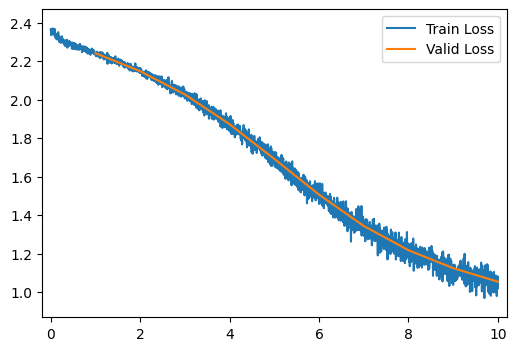

[10/10] Train Loss = 1.0788; Valid Loss = 1.0541; Valid Accuracy = 66.2%


In [11]:
run_model(optimizer=MomentumOptimizer)

#### **Q3**

Now let's try the *RMSProp optimizer*. Recall that the update equations for RMSProp can be written as follows:

$$ \mathbf{s}^{(k+1)} \longleftarrow \beta \mathbf{s}^{(k)} + (1-\beta) (\nabla_{\mathbf{w}} \textbf{Loss}(\mathbf{w}^{(k)}, \mathbf{X}, \mathbf{y}))^2$$
$$ \mathbf{w}^{(k+1)} \longleftarrow \mathbf{w}^{(k)} - \alpha \frac{\nabla_{\mathbf{w}} \textbf{Loss}(\mathbf{w}^{(k)}, \mathbf{X}, \mathbf{y})}{\sqrt{\mathbf{s}^{(k+1)} + \epsilon}}$$


Fill in the implementation of `RMSPropOptimizer` below, according to the update equations above.

In [12]:
epsilon = 1e-7
class RMSPropOptimizer(SGDOptimizer):
    # RMSProp Optimizer
    def __init__(self, parameters, lr=0.01, beta=0.9):
        # Set the learning rate
        self.lr = lr
        # Set the scale update rate
        self.beta = beta
        # Store the set of parameters that we'll be optimizing
        self.parameters = list(parameters)
        # Store any values that you'll need for RMSProp here
        self.scale = [torch.zeros_like(param) for param in self.parameters]
        # YOUR CODE HERE     

    def step(self):
        # Take a step of gradient descent
        for ind, parameter in enumerate(self.parameters):
            # First compute any updates needed for RMSProp here
            # YOUR CODE HERE
            self.scale[ind] = self.beta * self.scale[ind] + (1 - self.beta) * (parameter.grad ** 2)

            # Then compute the update to the parameter
            update = self.lr * parameter.grad / torch.sqrt(self.scale[ind] + epsilon)# YOUR CODE HERE

            # Finally update the parameter as before
            parameter -= update 

#### **Q4** 
Train and evaluate the model using the `RMSPropOptimizer` by running the cell below. Do the results seem different from the `SGDOptimizer`? Why do you think this might be?

*RMSProp converges much faster than SGD. As we saw in class, this could be because it accounts for the scaling in different dimensions.*

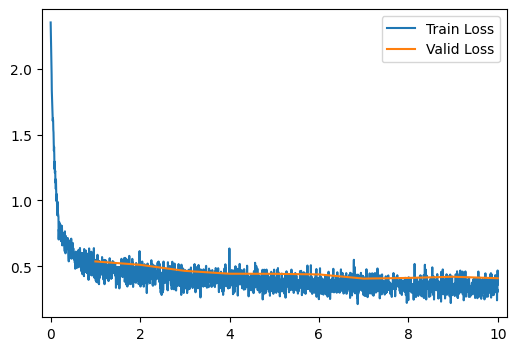

[10/10] Train Loss = 0.3410; Valid Loss = 0.4094; Valid Accuracy = 85.4%


In [13]:
run_model(optimizer=RMSPropOptimizer)

#### **Q5**

Finally let's try the *Adam optimizer*. Recall that the update equations for Adam can be written as follows:

$$ \mathbf{v}^{(k+1)} \longleftarrow \beta_1 \mathbf{v}^{(k)} + (1-\beta_1) \nabla_{\mathbf{w}} \textbf{Loss}(\mathbf{w}^{(k)}, \mathbf{X}, \mathbf{y})$$
$$ \mathbf{s}^{(k+1)} \longleftarrow \beta_2 \mathbf{s}^{(k)} + (1-\beta_2) (\nabla_{\mathbf{w}} \textbf{Loss}(\mathbf{w}^{(k)}, \mathbf{X}, \mathbf{y}))^2$$
$$ \mathbf{w}^{(k+1)} \longleftarrow \mathbf{w}^{(k)} - \alpha \frac{\frac{\mathbf{v}^{(k+1)}}{(1-\beta_1^k)}
}{\sqrt{\frac{\mathbf{s}^{(k+1)}}{(1-\beta_2^k)} + \epsilon}}$$


Fill in the implementation of `AdamOptimizer` below, according to the update equations above.

In [14]:
epsilon = 1e-7
class AdamOptimizer(SGDOptimizer):
    # Adam optimizer
    def __init__(self, parameters, lr=0.01, beta1=0.9, beta2=0.99):
        # Set the learning rate
        self.lr = lr
        # Set the scale update rate
        self.beta1 = beta1
        self.beta2 = beta2
        
        # Store the set of parameters that we'll be optimizing
        self.parameters = list(parameters)
        # Store any values that you'll need for Adam here
        self.velocity = [torch.zeros_like(param) for param in self.parameters]
        self.scale = [torch.zeros_like(param) for param in self.parameters]
        # YOUR CODE HERE     

    def step(self):
        # Take a step of gradient descent
        for ind, parameter in enumerate(self.parameters):
            # First compute any updates needed for Adam here
            # YOUR CODE HERE
            self.velocity[ind] = self.beta1 * self.velocity[ind] + (1 - self.beta1) * parameter.grad
            self.scale[ind] = self.beta2 * self.scale[ind] + (1 - self.beta2) * (parameter.grad ** 2)

            # Then compute the update to the parameter
            update = self.lr * self.velocity[ind] / torch.sqrt(self.scale[ind] + epsilon)# YOUR CODE HERE

            # Finally update the parameter as before
            parameter -= update 

#### **Q6** 
Train and evaluate the model using the `AdamOptimizer` by running the cell below. Do the results seem different from the `SGDOptimizer`? Why do you think this might be?

*The loss is better than both RMSProp and momentum alone, suggesting that combining the two approaches is useful.*

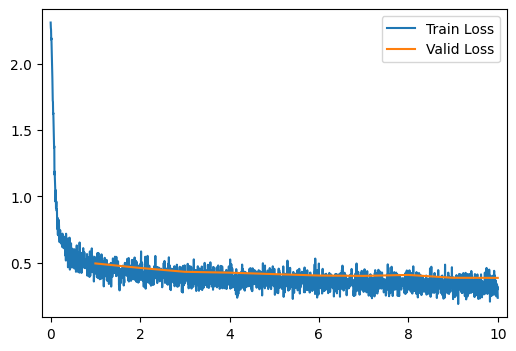

[10/10] Train Loss = 0.3270; Valid Loss = 0.3861; Valid Accuracy = 86.1%


In [15]:
run_model(optimizer=AdamOptimizer)

# Part 3: Normalization and Residual Networks

#### **Q7**

Try training a 20 layer network by running the cell below. What do you notice happening? Why does this happen?

*The model doesn't learn at all! This could be because of vanishing/exploding gradients*

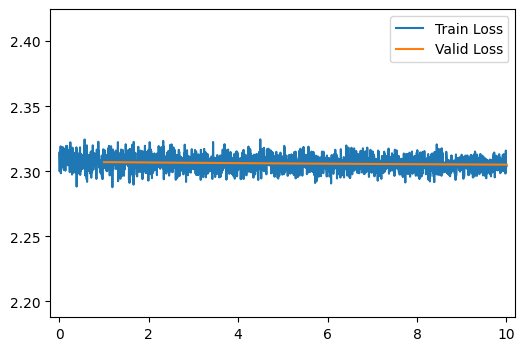

[10/10] Train Loss = 2.3052; Valid Loss = 2.3051; Valid Accuracy = 10.0%


In [16]:
run_model(number_of_hidden_layers=20)

#### **Q8**

Let's try applying normalization, starting with *Layer Normalization*. 

Assume we have a data matrix $\mathbf{X} \in \mathbb{R}^{N \times d}$, (i.e. $\mathbf{X}$ is an $N \times d$ matrix), such that:
$$N:\ \text{Number of observations}$$
$$d:\ \text{Number of features}$$
Then we can define layer normalization as a function that normalizes the *rows* of this matrix. We can define this function element-wise as:
$$\text{LayerNorm}(\mathbf{X})_{ij} = \frac{\mathbf{X}_{ij} - \mathbf{\bar{x}}_i}{\sqrt{\mathbf{s}^2_{i} + \epsilon}}$$
$$\mathbf{\bar{x}}_i = \frac{1}{d} \sum_{k=1}^d \mathbf{X}_{ik}, \quad \mathbf{s}^2_{i} = \frac{1}{d-1}\sum_{k=1}^d \big( \mathbf{X}_{ik} - \mathbf{\bar{x}}_i \big)^2$$

Complete the implementation of Layer Normalization below:

In [17]:
epsilon = 1e-7
class LayerNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        xmean = x.mean(dim=1, keepdims=True)
        xvar = x.var(dim=1, keepdims=True)
        return (x - xmean) / torch.sqrt(xvar + epsilon)
    
# Replace our Layer class with one that includes layer normalization
class LayerNormLayer(nn.Module):
    def __init__(self, in_dimensions, out_dimensions):
        super().__init__()
        self.linear = nn.Linear(in_dimensions, out_dimensions)
        self.layer_norm = LayerNorm()
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.linear(x)
        x = self.layer_norm(x)
        x = self.activation(x)
        return x

#### **Q9**

Train and evaluate a 20-layer network with layer normalization by running the cell below. What changed from the run without layer normalization? Why?

*Now the model learns! Layer normalization helped address the vanishing gradient problem.*

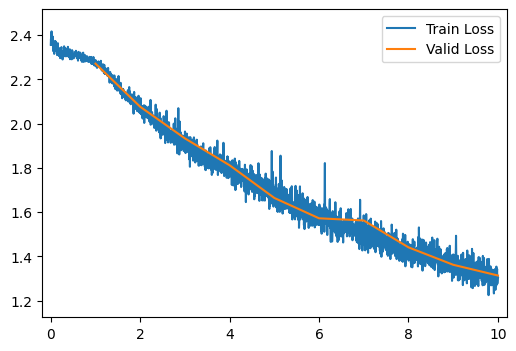

[10/10] Train Loss = 1.3322; Valid Loss = 1.3138; Valid Accuracy = 69.7%


In [18]:
run_model(number_of_hidden_layers=20, layer_type=LayerNormLayer)

#### **Q10**

Now let's try a *Batch Normalization*. 

Assume we have the same data matrix $\mathbf{X} \in \mathbb{R}^{N \times d}$ described above.

We can define batch normalization as a function that normalizes the *columns* of this matrix. We can define this function element-wise as:
$$\text{BatchNorm}(\mathbf{X})_{ij} = \frac{\mathbf{X}_{ij} - \mathbf{\bar{x}}_j}{\sqrt{\mathbf{s}^2_{j} + \epsilon}}$$
$$\mathbf{\bar{x}}_j = \frac{1}{d} \sum_{k=1}^d \mathbf{X}_{kj}, \quad \mathbf{s}^2_{j} = \frac{1}{d-1}\sum_{k=1}^d \big( \mathbf{X}_{kj} - \mathbf{\bar{x}}_j \big)^2$$
Recall that at *training time* we will also update running estimates of the batch mean and variance:
$$\mathbf{\bar{\mu}}_j^{(k+1)} \longleftarrow \beta \mathbf{\bar{\mu}}^{(k)}_j + (1-\beta) \mathbf{\bar{x}}_j$$
$$\mathbf{\bar{\sigma}}_j^{2(k+1)} \longleftarrow \beta \mathbf{\bar{\sigma}}^{2(k)}_j + (1-\beta) \mathbf{\bar{s}}^2_j$$
At *test/evaluation* time we will use these estimates:
$$\underset{\text{Test}}{\text{BatchNorm}}(\mathbf{X})_{ij} = \frac{\mathbf{X}_{ij} - \mathbf{\bar{x}}_j}{\sqrt{\mathbf{s}^2_{j} + \epsilon}}$$

Complete the implementation of Batch Normalization below:

In [19]:
epsilon = 1e-7
class BatchNorm(nn.Module):
    def __init__(self, dimensions, beta=0.9):
        super().__init__()
        self.beta=beta
        self.running_mean = torch.zeros((1, dimensions))
        self.running_var = torch.ones((1, dimensions))

    def forward(self, x):
        # Needed for GPU compatibility
        self.running_mean = self.running_mean.to(x.device)
        self.running_var = self.running_var.to(x.device)
        
        if self.training:
            xmean = x.mean(dim=0, keepdims=True)
            xvar = x.var(dim=0, keepdims=True)
            self.running_mean *= self.beta
            self.running_var *= self.beta

            
            self.running_mean += (1 - self.beta) * xmean
            self.running_var += (1 - self.beta) * xvar
            return (x - xmean) / torch.sqrt(xvar + epsilon)
        else:
            return (x - self.running_mean) / torch.sqrt(self.running_var + epsilon)
        
class BatchNormLayer(nn.Module):
    def __init__(self, in_dimensions, out_dimensions):
        super().__init__()
        self.linear = nn.Linear(in_dimensions, out_dimensions)
        self.layer_norm = BatchNorm(out_dimensions)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.linear(x)
        x = self.layer_norm(x)
        x = self.activation(x)
        return x

#### **Q11**

Train and evaluate a 20-layer network with batch normalization by running the cell below. What changed from the run without normalization? Why?

*Batch normalization also allows our very deep model to train, though the results are less good than layer normalization.*

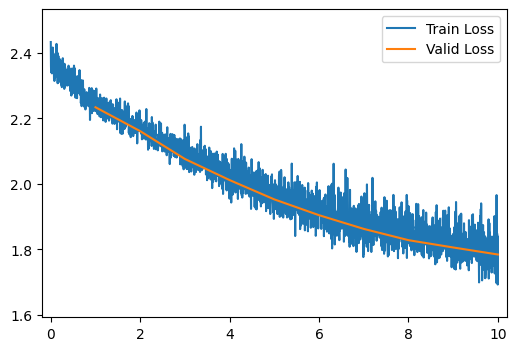

[10/10] Train Loss = 1.8071; Valid Loss = 1.7844; Valid Accuracy = 38.4%


In [20]:
run_model(number_of_hidden_layers=20, layer_type=BatchNormLayer)

#### **Q12**

Finally, let's try a residual network!

Recall that a standard neural network layer with a `ReLU` activation can be written as:

$$\phi(\mathbf{X}) = \text{ReLU}(\mathbf{X}\mathbf{W}^T + \mathbf{b})$$

A *residual layer* in contrast can be written as:
$$\phi_{res}(\mathbf{X}) = \text{ReLU}(\mathbf{X}\mathbf{W}^T + \mathbf{b}) + \mathbf{X}$$

Complete the residual layer implementation below. You may assume that the input and output size of this layer are the same.

In [21]:
class ResidualLayer(nn.Module):
    def __init__(self, dimensions, *args):
        super().__init__()
        self.linear = nn.Linear(dimensions, dimensions)
        self.activation = nn.ReLU()

    def forward(self, x):
        x_og = x
        x = self.linear(x)
        x = self.activation(x) + x_og
        return x

#### **Q13**

Try running a residual network using the cell below. How did this network perform? Why?

*The residual network also addresses the vanishing gradient problem, but the results are still not as good as the shallower network or the network with layer normalization.*

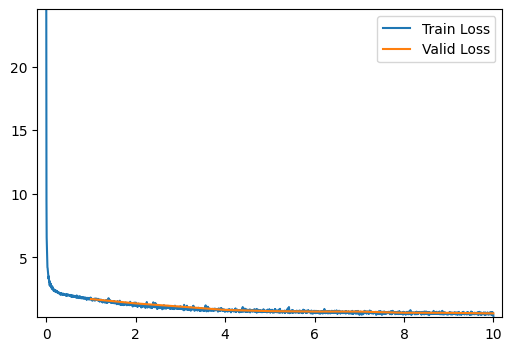

[10/10] Train Loss = 0.5953; Valid Loss = 0.6031; Valid Accuracy = 77.7%


In [22]:
run_model(number_of_hidden_layers=20, layer_type=ResidualLayer)